In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fft import fft, fftfreq
from glob import glob
import os


In [59]:


direc = r'Xenopus videos for Shanda\4h TREATMENT\TREATMENT/CONTROL/'
direc = r'D:\Work\Megan_tail_assay\Kostyantyn_230505_MP\WB3\8H\recovery\wb3/'
direc = r'C:\Users\kostya\Documents\Code\heart_seg\AVI Day 1&2/'
# direc = r'C:\Users\kostya\Documents\Code\heart_seg\AVI Day 3/'

vids = glob(direc+'*.avi*')
vids = [v for v in vids if 'stabilized' not in v]
diffs = []
bmask = []
for v in vids[0:10]:
    backSub = cv2.bgsegm.createBackgroundSubtractorLSBP()
    cap = cv2.VideoCapture(v)
    diffs_vid = []
    ret, frame = cap.read()
    if not ret:
        continue
    bmask_vid = []
    prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgmask = np.zeros_like(prev_gray)
    cv2.circle(fgmask, (np.shape(fgmask)[1]//2, np.shape(fgmask)[0]//2), 245, 255, -1)
    prev_gray = cv2.bitwise_and(fgmask, prev_gray)
    r = cv2.selectROI("select area", prev_gray)
    cv2.destroyAllWindows()
    prev_cropped = prev_gray[int(r[1]):int(r[1]+r[3]), 
                      int(r[0]):int(r[0]+r[2])]
    # plt.imshow(prev_gray, cmap='gray')
    # plt.show()
    # break
    cnt = 0
    while cnt <=300:
        ret, frame = cap.read()
        if not ret:
            break
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.bitwise_and(fgmask, curr_gray)
        curr_cropped = curr_gray[int(r[1]):int(r[1]+r[3]), 
                      int(r[0]):int(r[0]+r[2])]
        diff = cv2.subtract(prev_gray, curr_gray)
        diffs_vid.append(np.sum(diff))
        prev_gray = curr_gray
        pref_cropped = curr_cropped
        cv2.imshow('main', diff)
        cv2.waitKey(1)
        cnt+=1

    diffs.append(diffs_vid)
    bmask.append(bmask_vid)
cv2.destroyAllWindows()
        
    

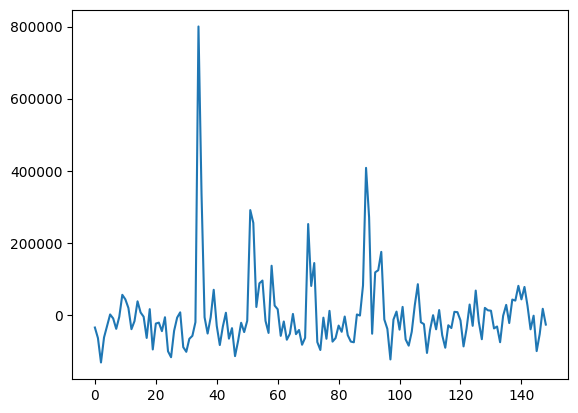

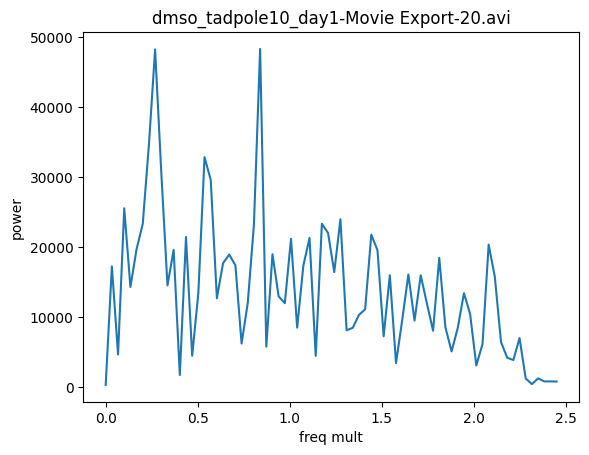

dmso_tadpole10_day1-Movie Export-20.avi bpm [50.33557047]


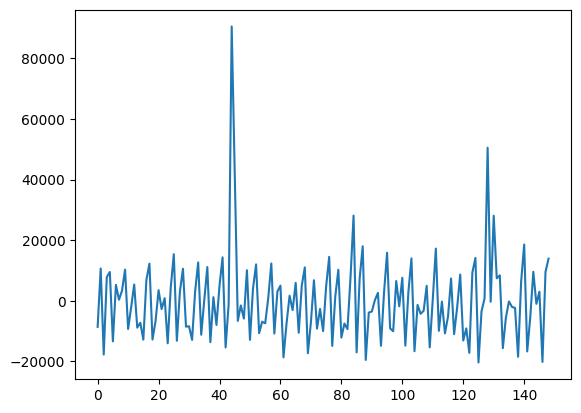

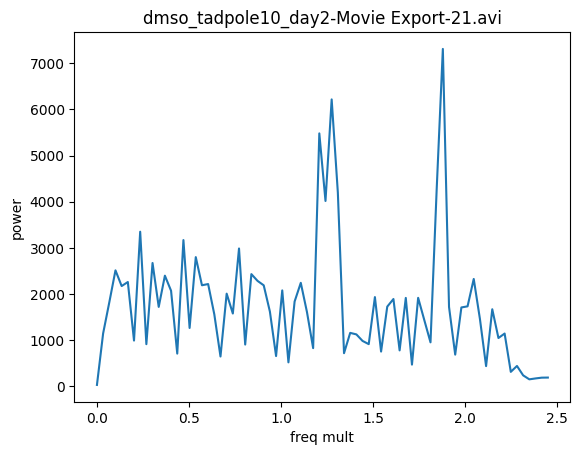

dmso_tadpole10_day2-Movie Export-21.avi bpm [112.75167785]


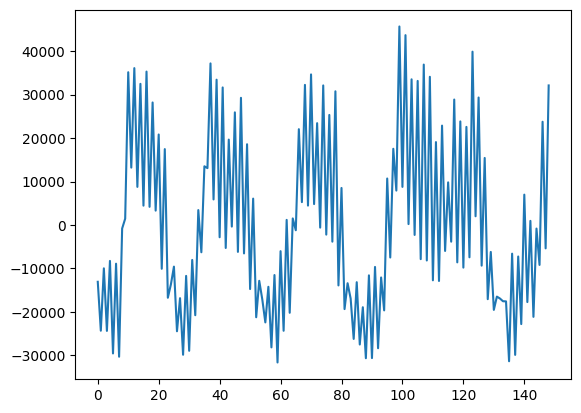

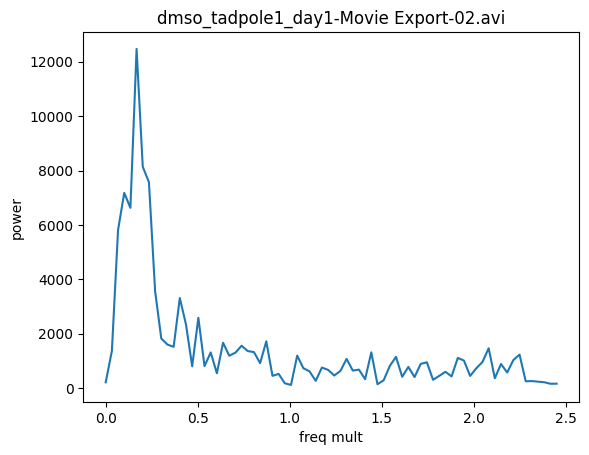

dmso_tadpole1_day1-Movie Export-02.avi bpm [10.06711409]


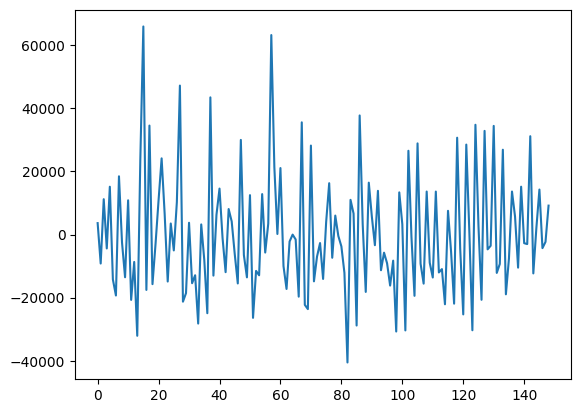

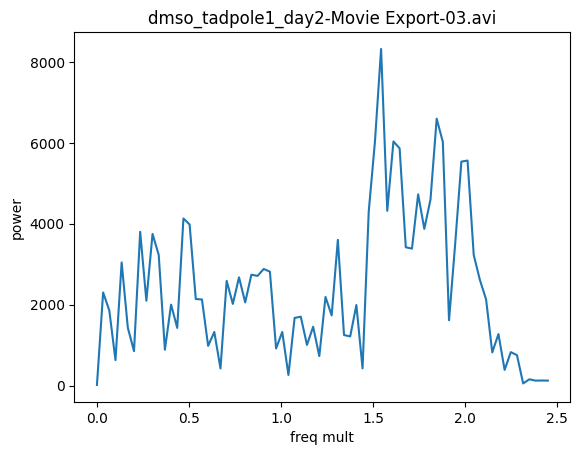

dmso_tadpole1_day2-Movie Export-03.avi bpm [92.61744966]


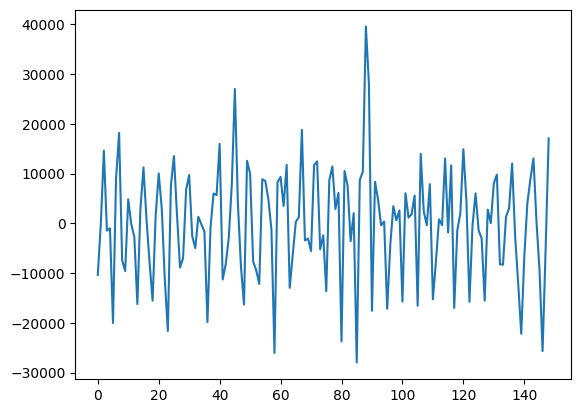

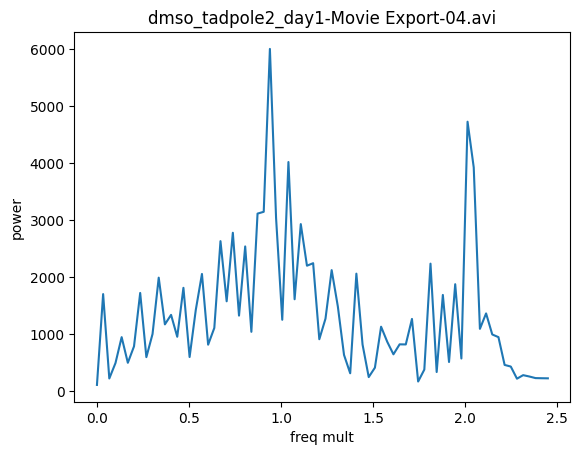

dmso_tadpole2_day1-Movie Export-04.avi bpm [56.37583893]


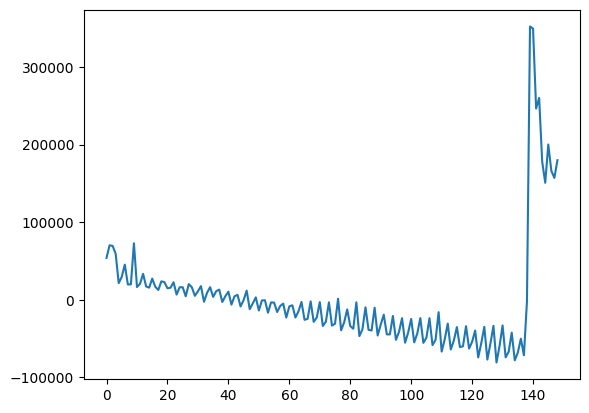

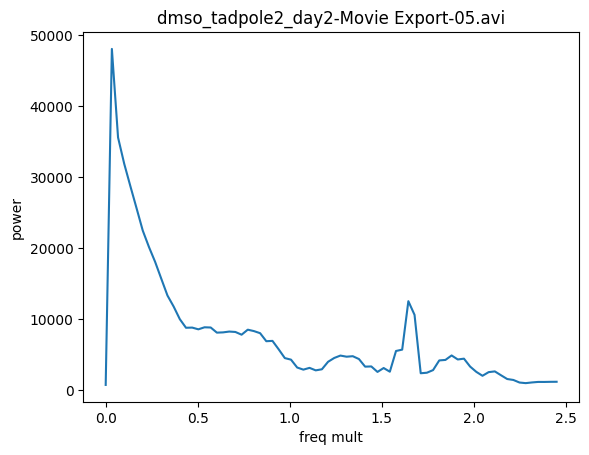

dmso_tadpole2_day2-Movie Export-05.avi bpm [8.05369128]


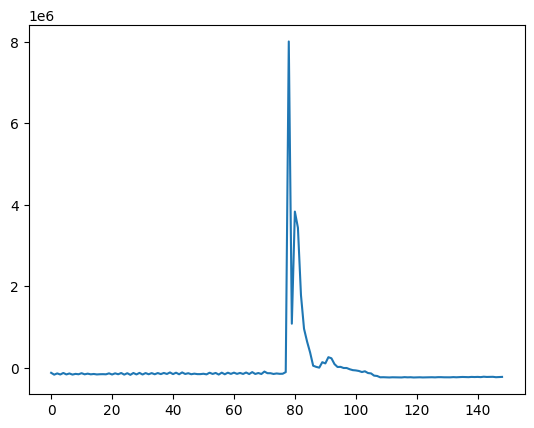

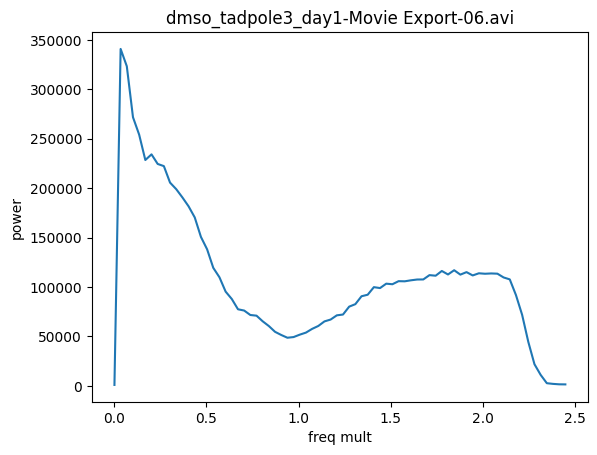

dmso_tadpole3_day1-Movie Export-06.avi bpm [8.05369128]


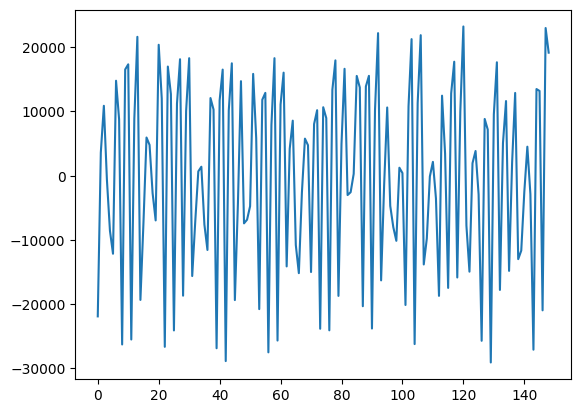

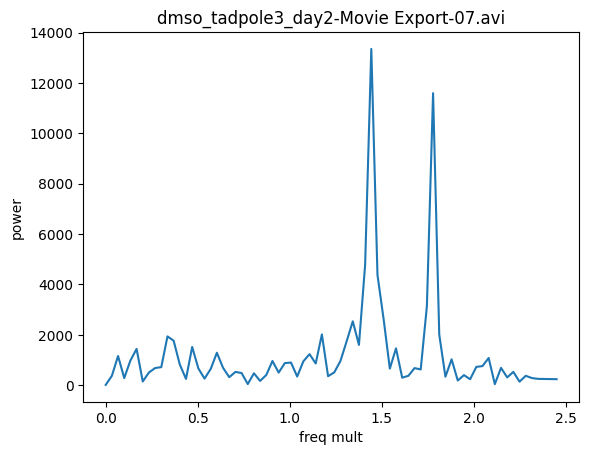

dmso_tadpole3_day2-Movie Export-07.avi bpm [86.57718121]


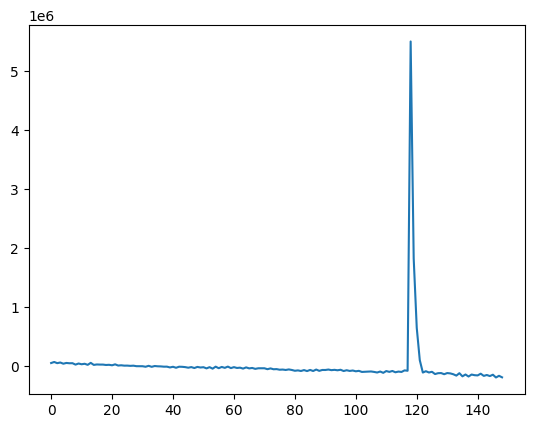

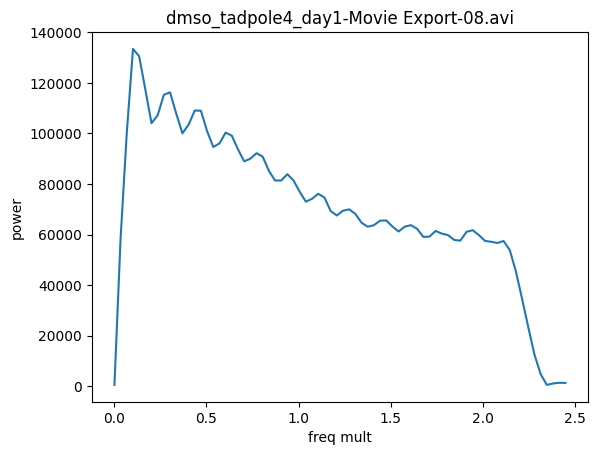

dmso_tadpole4_day1-Movie Export-08.avi bpm [8.05369128]


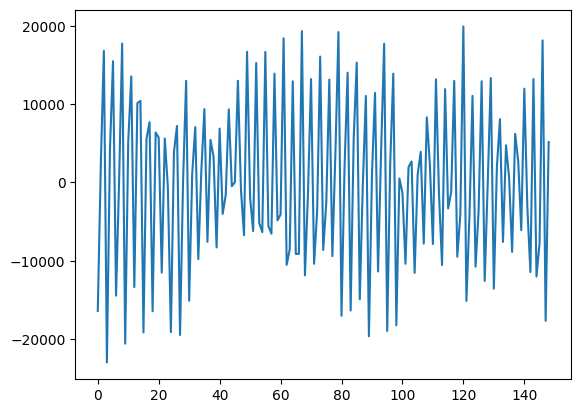

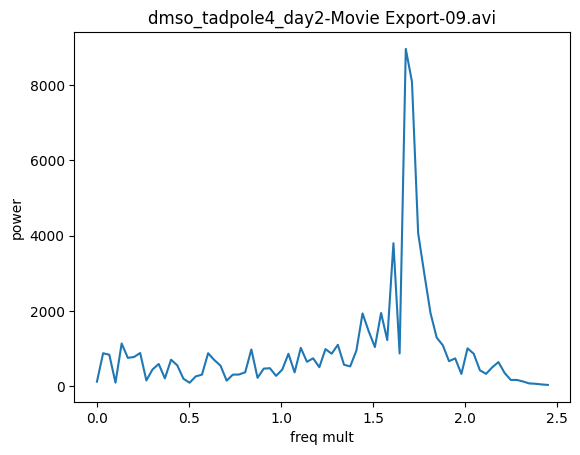

dmso_tadpole4_day2-Movie Export-09.avi bpm [100.67114094]


In [60]:
f = signal.butter(5, 2.2, 'low', fs=5, output='sos')
bpm_d = {}
diffs = [d for d in diffs if len(d) > 100]
for ct, d in enumerate(diffs):
    vidname = vids[ct].split('\\')[-1]
    detrended = signal.detrend(d[150:300])
    
    detrended = detrended - np.mean(detrended)
    # detrended[np.where(detrended > 2*np.mean(detrended))] = 0
    plt.plot(detrended)
    plt.show()
    filtered = signal.sosfilt(f, detrended)
    N = len(detrended)
    T = 1/5
    yf = fft(filtered)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N*np.abs(yf[0:N//2]))
    plt.title(f'{vidname}')
    plt.xlabel('freq mult')
    plt.ylabel('power')
    fname = direc+vidname.strip('.avi')+'_fft.png'
    plt.savefig(fname)
    plt.show()
    print(f'{vidname} bpm', xf[np.where(2.0/N*np.abs(yf[0:N//2]) == max(2.0/N*np.abs(yf[4:N//2])))]*60)
    bpm_d[vidname] = xf[np.where(2.0/N*np.abs(yf[0:N//2]) == max(2.0/N*np.abs(yf[4:N//2])))]*60

10.06711409395973
10.06711409395973
80.53691275167785
64.42953020134227
50.335570469798654
8.053691275167784
4.026845637583892
76.51006711409396
2.013422818791946
94.63087248322147


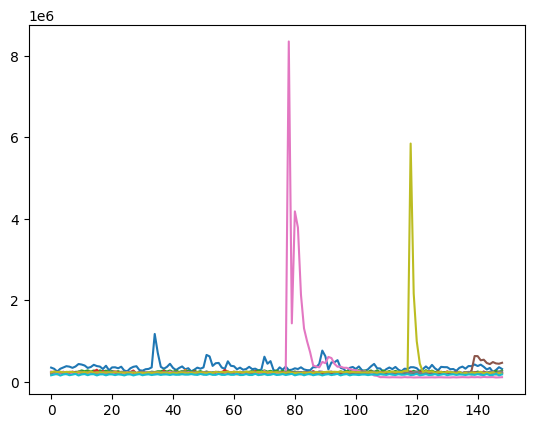

In [61]:

from scipy.signal import find_peaks
for i in diffs:
    sig = np.asarray(i[150:300])
    sig[np.where(sig > 1.5*10**7)] = 0
    plt.plot(sig)
    sig = signal.detrend(sig)
    peaks, _ = find_peaks(sig, prominence=1, height = np.max(sig)//5)
    
    # plt.plot(peaks, sig[peaks], "x")
    # plt.show()
    print(len(peaks)/(len(sig)/60)*5)

In [62]:
import csv

with open('day12.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    for i in bpm_d:
        writer.writerow([i, *bpm_d[i]])

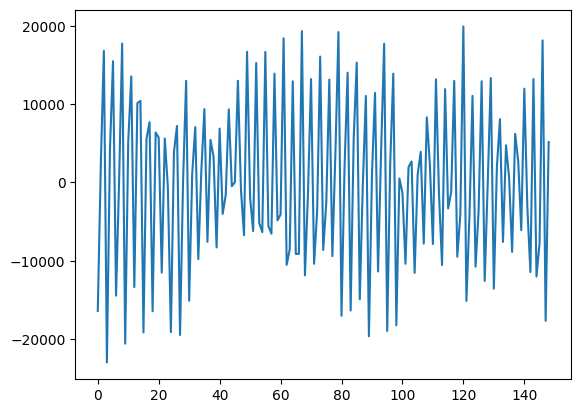

In [63]:
plt.plot(sig)